In [30]:
import numpy as np
from utils import *

### Read Subject and Data Preprocessing

In [ ]:
b3d_path = "data/AddBiomechanicsDataset./test/With_Arm/Fregly2012_Formatted_With_Arm/3GC/3GC.b3d"
trial_num = 12

subject = nimble.biomechanics.SubjectOnDisk(b3d_path)
cop, grf, marker_clouds, subject_mass = load_data_b3d(b3d_path, trial_num=trial_num)

markers_for_centroid = np.array([1, 3, 31, 11, 16, 17, 26, 27, 29, 39, 44, 45 ,54, 55, 56, 58]) # Fregly2012 torso markers
com = np.nanmean(marker_clouds[:,markers_for_centroid,:], axis=1)

subject_name = f"fregly {trial_num}"

frames = subject.readFrames(
        trial=trial_num,
        startFrame=0,
        numFramesToRead=subject.getTrialLength(trial_num),
        includeProcessingPasses=True  # This is the correct parameter if you need processing passes
    )

# frames[10].markerObservations is assumed to be a list of pairs (tuples or lists)
print([(i, pair[0]) for i, pair in enumerate(frames[10].markerObservations)])

[(0, 'LAJC'), (1, 'LAsis'), (2, 'LElbow'), (3, 'LHJC'), (4, 'LHeel'), (5, 'LHindfoot'), (6, 'LKJC'), (7, 'LMidfootLateral'), (8, 'LMidfootMedial'), (9, 'LMidfootSuperior'), (10, 'LPatella'), (11, 'LPsis'), (12, 'LRadius'), (13, 'LShankInferior'), (14, 'LShankLateral'), (15, 'LShankSuperior'), (16, 'LShoulder'), (17, 'LShoulderCenter'), (18, 'LThighInferior'), (19, 'LThighLateral'), (20, 'LThighSuperior'), (21, 'LToe'), (22, 'LToeLateral'), (23, 'LToeMedial'), (24, 'LUlna'), (25, 'LWrist'), (26, 'Lumbar'), (27, 'Neck'), (28, 'RAJC'), (29, 'RAsis'), (30, 'RElbow'), (31, 'RHJC'), (32, 'RHeel'), (33, 'RHindfoot'), (34, 'RKJC'), (35, 'RMidfootLateral'), (36, 'RMidfootMedial'), (37, 'RMidfootSuperior'), (38, 'RPatella'), (39, 'RPsis'), (40, 'RRadius'), (41, 'RShankInferior'), (42, 'RShankLateral'), (43, 'RShankSuperior'), (44, 'RShoulder'), (45, 'RShoulderCenter'), (46, 'RThighInferior'), (47, 'RThighLateral'), (48, 'RThighSuperior'), (49, 'RToe'), (50, 'RToeLateral'), (51, 'RToeMedial'), (5

## Visualize Data
### Vertical Ground Reaction Force

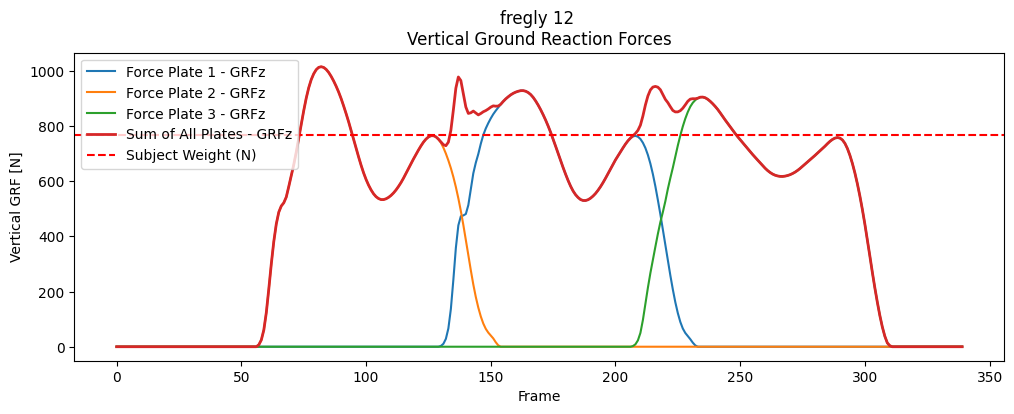

In [44]:
import matplotlib.pyplot as plt

# Plot the vertical GRF (z-component) for both force plates
plt.figure(figsize=(12, 4))
for plate in range(grf.shape[1]):
    plt.plot(grf[:, plate, 2], label=f'Force Plate {plate+1} - GRFz')
plt.plot(np.sum(grf[:, :, 2], axis=1), label='Sum of All Plates - GRFz', linewidth=2)
plt.axhline(subject_mass * 9.81, color='red', linestyle='--', label='Subject Weight (N)')
plt.xlabel('Frame')
plt.ylabel('Vertical GRF [N]')
plt.title(f'{subject_name} \nVertical Ground Reaction Forces')
plt.legend()
plt.show()

### Finite Differenced COM Dynamics

In [45]:
com_accel = np.zeros_like(com)
dt_markers = 1/100 # 100 Hz for marker data
# Calculate velocity using central differences
com_vel = np.zeros_like(com)
com_vel[1:-1] = (com[2:] - com[:-2]) / (2*dt_markers)

# Calculate acceleration using central differences
com_accel[1:-1] = (com[2:] - 2 * com[1:-1] + com[:-2]) / (dt_markers**2)


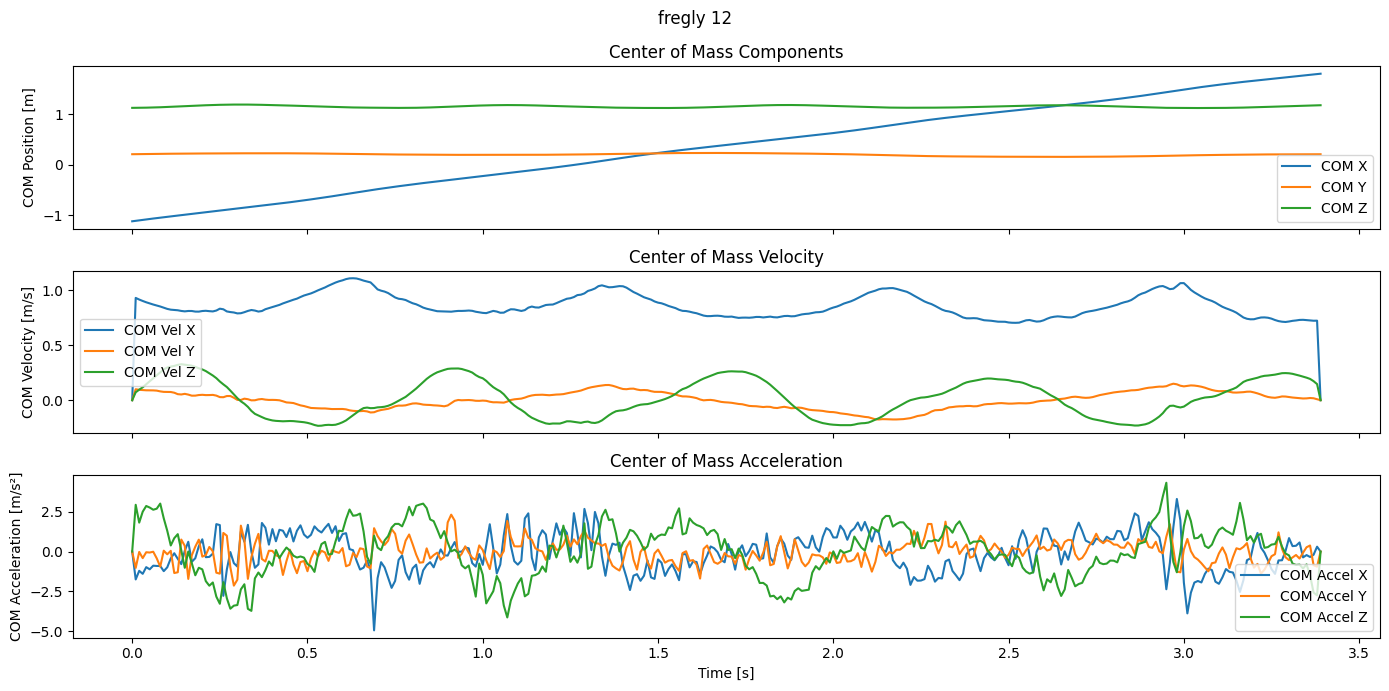

In [46]:
time = np.arange(com.shape[0]) * dt_markers  # dt_markers is the sampling frequency (Hz)

fig, axs = plt.subplots(3, 1, figsize=(14, 7), sharex=True)
fig.suptitle(f'{subject_name}')

# COM position
axs[0].plot(time, com[:, 0], label='COM X')
axs[0].plot(time, com[:, 1], label='COM Y')
axs[0].plot(time, com[:, 2], label='COM Z')
axs[0].set_ylabel('COM Position [m]')
axs[0].set_title('Center of Mass Components')
axs[0].legend()

# COM velocity
axs[1].plot(time, com_vel[:, 0], label='COM Vel X')
axs[1].plot(time, com_vel[:, 1], label='COM Vel Y')
axs[1].plot(time, com_vel[:, 2], label='COM Vel Z')
axs[1].set_ylabel('COM Velocity [m/s]')
axs[1].set_title('Center of Mass Velocity')
axs[1].legend()

# COM acceleration
axs[2].plot(time, com_accel[:, 0], label='COM Accel X')
axs[2].plot(time, com_accel[:, 1], label='COM Accel Y')
axs[2].plot(time, com_accel[:, 2], label='COM Accel Z')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('COM Acceleration [m/s²]')
axs[2].set_title('Center of Mass Acceleration')
axs[2].legend()

plt.tight_layout()
plt.show()

### Compare Marker COM Acceleration and Force Plate Predicted Acceleration

In [52]:
num_marker_frames = marker_clouds.shape[0]
num_grf_frames = grf.shape[0]
# Downsample cop and grf to match the number of frames in marker_clouds
com_accel_FP = np.zeros((num_grf_frames, 3))
if num_grf_frames > num_marker_frames:
    # Calculate the downsampling ratio
    ratio = float(num_grf_frames) / float(num_marker_frames)
    # Create indices for downsampling
    indices = np.arange(num_marker_frames) * ratio
    indices = np.round(indices).astype(int)
    grf = grf[indices]

com_accel_FP = np.sum(grf, axis=1)/subject_mass - np.array([0, 0, 9.81])

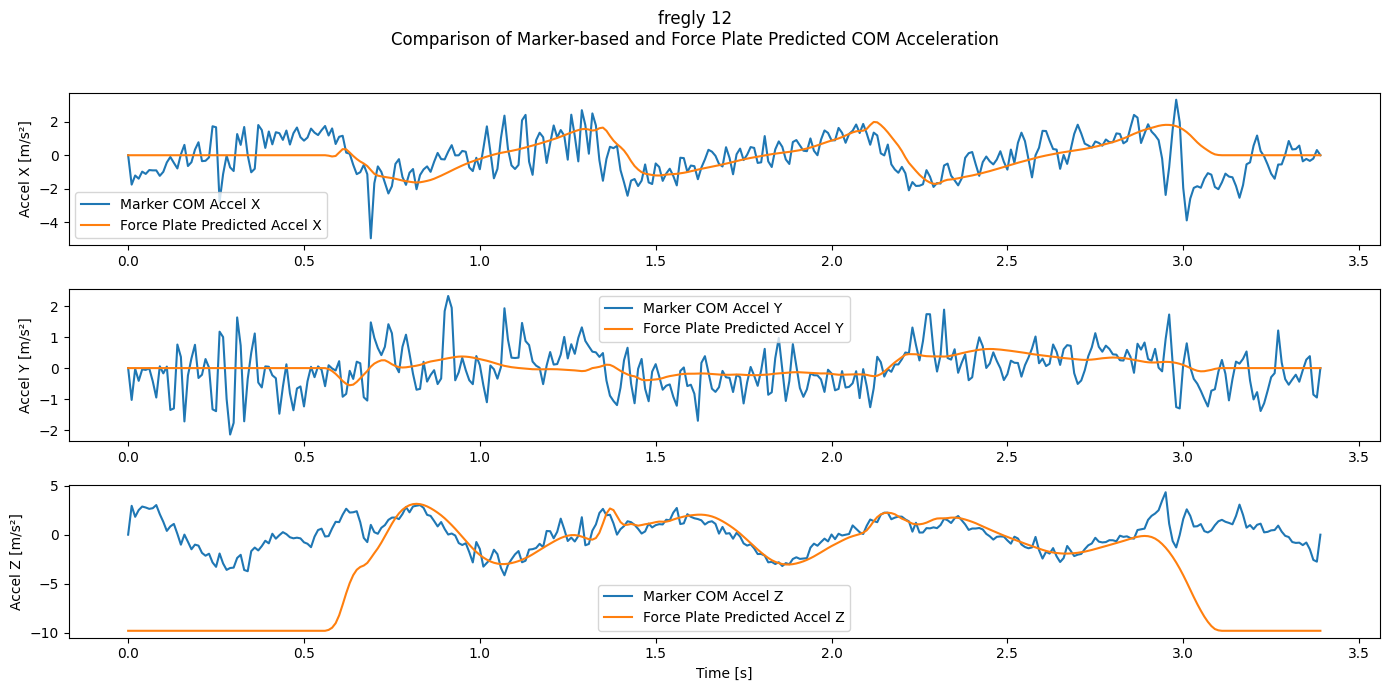

In [53]:
plt.figure(figsize=(14, 7))
labels = ['X', 'Y', 'Z']
units = ['[m/s²]', '[m/s²]', '[m/s²]']
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(time, com_accel[:, j], label='Marker COM Accel ' + labels[j])
    plt.plot(time, com_accel_FP[:, j], label='Force Plate Predicted Accel ' + labels[j])
    plt.ylabel(f'Accel {labels[j]} {units[j]}')
    plt.legend()
plt.xlabel('Time [s]')
plt.suptitle(f'{subject_name}\nComparison of Marker-based and Force Plate Predicted COM Acceleration')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()